In [2]:
import sys
import os.path
import pandas as pd
from pandas import read_csv
import numpy as np
import statistics
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sns
import math
import tensorflow
import keras
import sklearn
from keras_tuner import GridSearch, RandomSearch
from keras_tuner import HyperModel
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
print (sys.version_info)
print ("NumPy: ", np.__version__)
print ("Pandas: ", pd.__version__)
print ("TensorFlow: ", tensorflow.__version__)
print ("Keras: ", keras.__version__)
print ("SciKitLearn: ", sklearn.__version__)

sys.version_info(major=3, minor=11, micro=5, releaselevel='final', serial=0)
NumPy:  1.26.0
Pandas:  2.0.3
TensorFlow:  2.15.0
Keras:  2.15.0
SciKitLearn:  1.2.2


## Importación de los datos

In [4]:
dfBikesHour = pd.read_csv("dataset/hour.csv")
print(len(dfBikesHour.index), ' registros')

17379  registros


In [5]:
print('{n} COLUMNAS'.format(n = len(dfBikesHour.columns)))
print(dfBikesHour.columns)
print('\n\nPrimeros 5 registros')
display(dfBikesHour.head(5).style)
print('\n\nÚltimos 5 registros')
display(dfBikesHour.tail(5).style)

17 COLUMNAS
Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')


Primeros 5 registros


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.240000,0.287900,0.810000,0.000000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.220000,0.272700,0.800000,0.000000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.220000,0.272700,0.800000,0.000000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.240000,0.287900,0.750000,0.000000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.240000,0.287900,0.750000,0.000000,0,1,1




Últimos 5 registros


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.260000,0.257600,0.600000,0.164200,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.260000,0.257600,0.600000,0.164200,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.260000,0.257600,0.600000,0.164200,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.260000,0.272700,0.560000,0.134300,13,48,61
17378,17379,2012-12-31,1,1,12,23,0,1,1,1,0.260000,0.272700,0.650000,0.134300,12,37,49


In [6]:
dfBikesHour.sort_values(['instant'], inplace=True)
dfBikesHour.dropna(inplace=True)
print(len(dfBikesHour.index), ' registros')

17379  registros


## Funciones

In [7]:
#Funcion para crear la entrada y la salida de la red, adaptada para recibir DataFrames de pandas con la entrada y la salida,
#y n_steps, que es la historia
def CreaDatos(X, y, n_steps):
    input_sequence, output = [], []
    for i in range(len(X)-n_steps):
        # Localizamos el final de la secuencia
        end_ix = i + n_steps
        # Recogemos entradas y salidas.
        seq_x, seq_y = X.iloc[i:end_ix].values, y.iloc[end_ix]
        input_sequence.append(seq_x)
        output.append(seq_y)
    return np.array(input_sequence), np.array(output)


def Visualiza (titulo2):
    # El argumento titulo2 es para personalizar las gráficas.
    # Hace predicciones
    # Desnormaliza las salidas reales y de la red para poder 
    # visualizar temperaturas correctamente.
    # El parámetro batch_size es indispensable en las redes LSTM apiladas con memoria;
    # en otros modelos, no se usa.
    testPredict = model.predict(testX, batch_size=BATCHSIZE)
    testPredict = cnt_transformer.inverse_transform(testPredict)
    testReal=cnt_transformer.inverse_transform(testY.reshape(-1,1))
    
    # Cálculo del error cuadrático medio.
    testScore = math.sqrt(mean_squared_error(testReal, testPredict.reshape(-1,1)))
    print('Test Score: %.2f RMSE' % (testScore))

    plt.plot(testPredict[0:240], label="Predict")
    plt.plot(testReal[0:240], label="Real")
    plt.legend()
    plt.title("Prediccion de bicicletas alquiladas por hora.\n"+titulo2+" Historia="+str (Historia)+" Epocas="+str (EPOCAS))
    plt.show()    
    return

## Visualización de los datos

La variable a predecir es el número de bicicletas alquiladas por día según mes, día de la semana, temperatura, y otras variables según las que tenemos que predecir dicho número. La variable a predecir es la correspondiente a la columna 'cnt', que es la suma de 'casual' y 'registered'. Por tanto, estas dos últimas no se incluirán para entrenar.

A continuación se muestra un pequeño estudio estadístico sobre la variable a predecir, incluyendo algunas gráficas con respecto a otras variables, coeficientes de correlación, etcétera.

MEDIDAS DE CENTRALIZACIÓN

Media: 189.46308763450142
Mediana: 142.0
Moda: 5


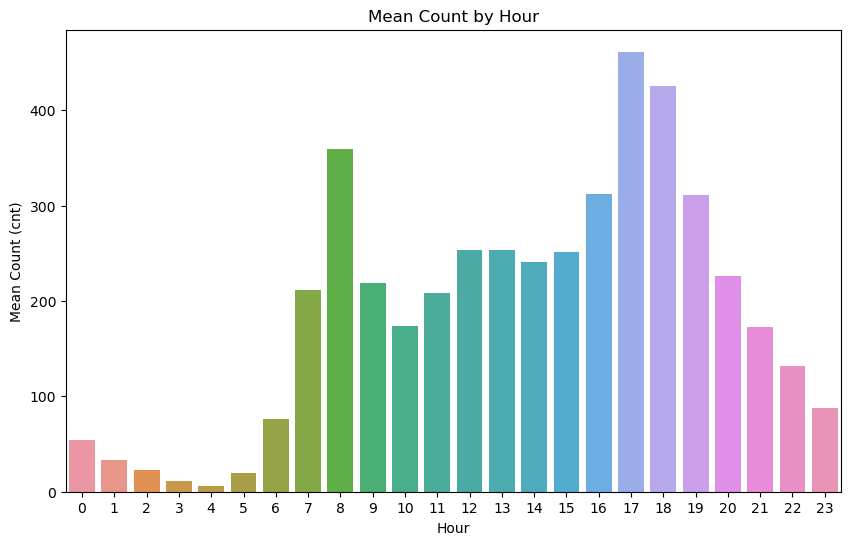



MEDIDAS DE VARIABILIDAD

Desviación típica: 181.38759909186476
Varianza: 32901.461104311056
Máximo: 977
Mínimo: 1
Rango: 976


Estadística descriptiva para todas las columnas aportada por pandas


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


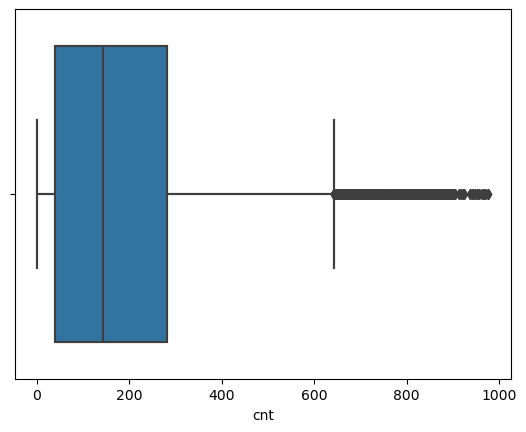

In [8]:
print("MEDIDAS DE CENTRALIZACIÓN\n")

print("Media: {m}".format(m = np.mean(dfBikesHour['cnt'])))
print("Mediana: {median}".format(median = np.median(dfBikesHour['cnt'])))
print("Moda: {mode}".format(mode = statistics.mode(dfBikesHour['cnt'])))

mean_cnt_by_hour = dfBikesHour.groupby('hr')['cnt'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='hr', y='cnt', data=mean_cnt_by_hour)

# Set labels and title
plt.xlabel('Hour')
plt.ylabel('Mean Count (cnt)')
plt.title('Mean Count by Hour')

# Show the plot
plt.show()

print("\n\nMEDIDAS DE VARIABILIDAD\n")

print("Desviación típica: {std}".format(std = statistics.stdev(dfBikesHour['cnt'])))
print("Varianza: {var}".format(var = statistics.variance(dfBikesHour['cnt'])))
print("Máximo: {max}".format(max = np.max(dfBikesHour['cnt'])))
print("Mínimo: {min}".format(min = np.min(dfBikesHour['cnt'])))
print("Rango: {range}".format(range = np.ptp(dfBikesHour['cnt'])))

sns.boxplot(x = dfBikesHour['cnt'])

# Equivalente a:
sns.boxplot(x = "cnt", data = dfBikesHour)

print("\n\nEstadística descriptiva para todas las columnas aportada por pandas")

dfBikesHour.loc[:, dfBikesHour.columns[1:]].describe()

In [9]:
dfBikesHour.columns[1:-3]

Index(['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,1.000000,0.404046,0.866014,0.489164,-0.004775,0.014723,0.001357,-0.003416,-0.014198,0.136178,0.137615,0.009577,-0.074505,0.158295,0.282046,0.278379
season,0.404046,1.000000,-0.010742,0.830386,-0.006117,-0.009585,-0.002335,0.013743,-0.014524,0.312025,0.319380,0.150625,-0.149773,0.120206,0.174226,0.178056
yr,0.866014,-0.010742,1.000000,-0.010473,-0.003867,0.006692,-0.004485,-0.002196,-0.019157,0.040913,0.039222,-0.083546,-0.008740,0.142779,0.253684,0.250495
mnth,0.489164,0.830386,-0.010473,1.000000,-0.005772,0.018430,0.010400,-0.003477,0.005400,0.201691,0.208096,0.164411,-0.135386,0.068457,0.122273,0.120638
hr,-0.004775,-0.006117,-0.003867,-0.005772,1.000000,0.000479,-0.003498,0.002285,-0.020203,0.137603,0.133750,-0.276498,0.137252,0.301202,0.374141,0.394071
holiday,0.014723,-0.009585,0.006692,0.018430,0.000479,1.000000,-0.102088,-0.252471,-0.017036,-0.027340,-0.030973,-0.010588,0.003988,0.031564,-0.047345,-0.030927
weekday,0.001357,-0.002335,-0.004485,0.010400,-0.003498,-0.102088,1.000000,0.035955,0.003311,-0.001795,-0.008821,-0.037158,0.011502,0.032721,0.021578,0.026900
workingday,-0.003416,0.013743,-0.002196,-0.003477,0.002285,-0.252471,0.035955,1.000000,0.044672,0.055390,0.054667,0.015688,-0.011830,-0.300942,0.134326,0.030284
weathersit,-0.014198,-0.014524,-0.019157,0.005400,-0.020203,-0.017036,0.003311,0.044672,1.000000,-0.102640,-0.105563,0.418130,0.026226,-0.152628,-0.120966,-0.142426
temp,0.136178,0.312025,0.040913,0.201691,0.137603,-0.027340,-0.001795,0.055390,-0.102640,1.000000,0.987672,-0.069881,-0.023125,0.459616,0.335361,0.404772


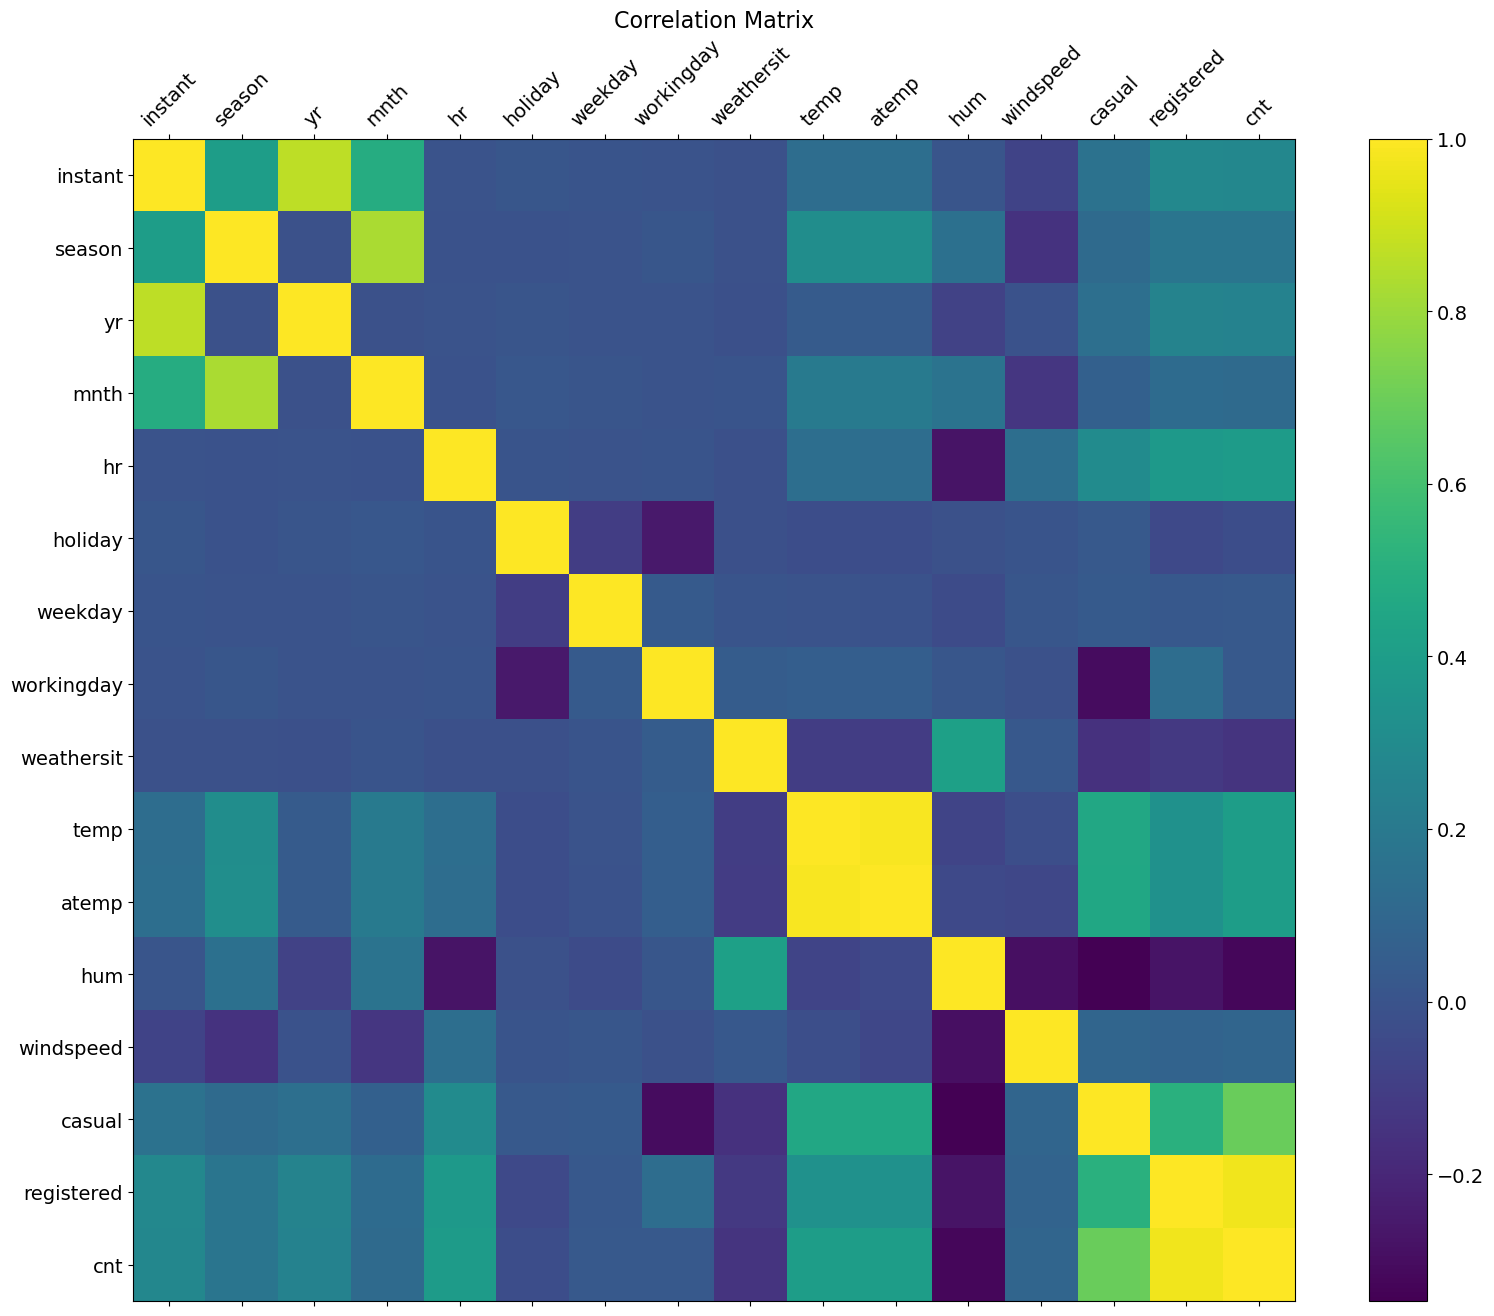

In [10]:
corr_matrix = dfBikesHour.select_dtypes(include='number').corr()

display(corr_matrix)

f = plt.figure(figsize=(19, 15))
plt.matshow(corr_matrix, fignum=f.number)
plt.xticks(range(dfBikesHour.select_dtypes(['number']).shape[1]), dfBikesHour.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(dfBikesHour.select_dtypes(['number']).shape[1]), dfBikesHour.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

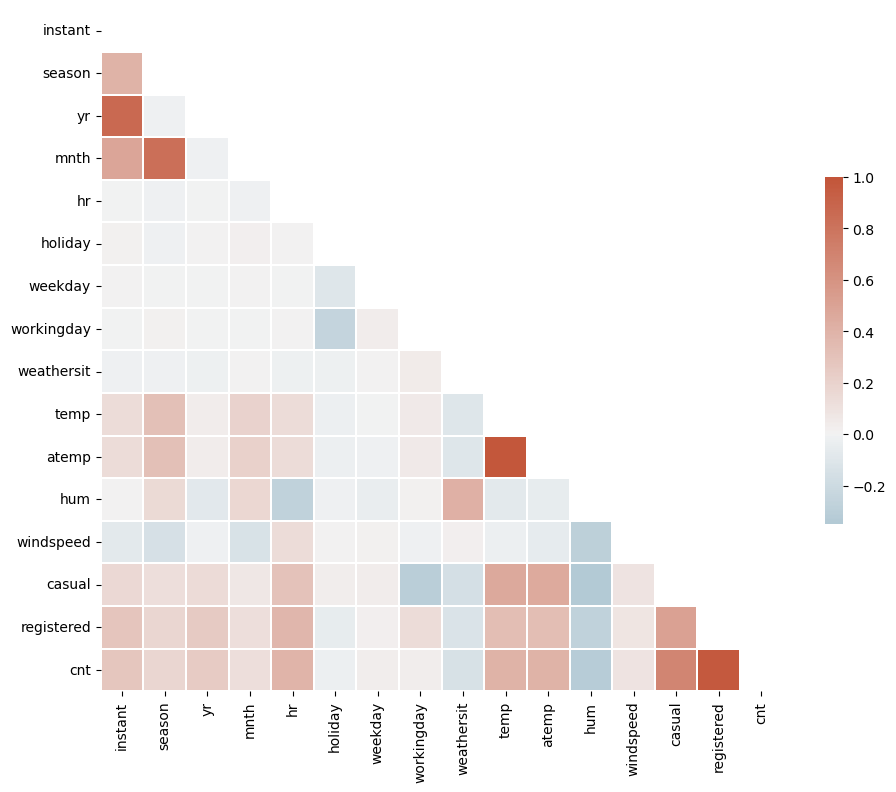

In [11]:
#Matriz de correlación diagonal con seaborn (se visualiza mejor así la matriz de correlación, pero se mantienen
#ambas formas por completitud

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
corr_seaborn = sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": .5})

MEDIDAS DE LA DISTRIBUCIÓN
Skewness 1.2774116037490577
Kurtosis 1.4172032806553756


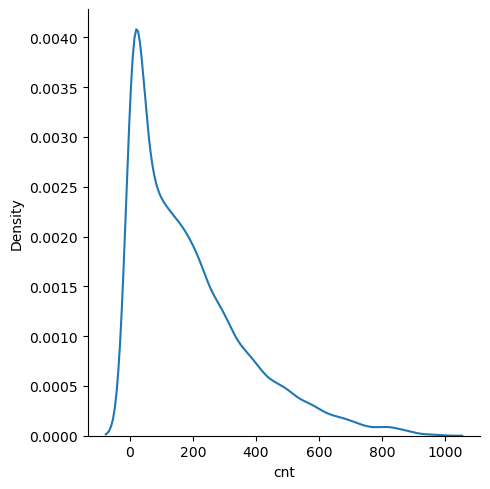

In [12]:
print("MEDIDAS DE LA DISTRIBUCIÓN")
print("Skewness {sk}".format(sk = dfBikesHour['cnt'].skew()))
print("Kurtosis {k}".format(k = dfBikesHour['cnt'].kurt()))

sns.displot(x = dfBikesHour['cnt'], kind='kde')

## Preparación de datos

In [13]:
print('Datos Sin Procesar\n')
display(dfBikesHour.head(1))

columnsToDrop = ['dteday', 'instant', 'casual', 'registered', 'atemp', 'yr', 'weekday']

df = dfBikesHour.drop(columns=columnsToDrop, inplace=False)

df = pd.get_dummies(df, prefix=['season'], columns=['season'], dtype=int)
df = pd.get_dummies(df, prefix=['weathersit'], columns=['weathersit'], dtype=int)

columnsToScale = ['cnt']

cnt_transformer = MinMaxScaler(feature_range=(0.1, 0.9)).fit(df[columnsToScale])
df[columnsToScale] = cnt_transformer.transform(df[columnsToScale])

# Dividimos el conjunto entre entrenamiento y prueba.
train_size = int(len(df) * 0.67)        # Un 67% de los datos para entrenamiento
test_size  = len(df) - train_size
train = df.iloc[0:train_size]         # Los datos son contiguos para entrenamiento
test  = df.iloc[train_size:len(df)]   # como para prueba.
print('\n\nDatos Procesados\n')
display(df.head(1))

Datos Sin Procesar



,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16




Datos Procesados



,mnth,hr,holiday,workingday,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,1,0,0,0,0.24,0.81,0.0,0.112295,1,0,0,0,1,0,0,0


# Creación de los Modelos - Entrenamiento, búsqueda de hiperparámetros, reentrenamiento y prueba

### Callbacks

In [14]:
my_callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=True, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=0.0005, factor=0.80, patience=1, verbose=True)
]

## Modelos

## LSTM para un problema de regresión

El modelo más sencillo sólo tiene una capa LSTM. Cuando se crean los datos, las entradas forman un tensor de forma

[número_ejemplos, tamaño_ventana_(lo que aquí llamamos $historia$), tamaño de un_ejemplo]

En este primer intento, la historia (ventana) es de 1 (sólo usamos los últimos datos para predecir el siguiente)

Se explica con comentarios el código para este modelo. Para el resto es análogo. En trabajos futuros se podría abstraer todo el código a una función o a una clase para evitar repetir partes del mismo.

In [15]:
#repeticion de los experimentos
N_EXECUTIONS_PER_TRIAL = 3
#numero de combinacones de hiperparametros
N_TRIALS = 10
#epocas por las que entrenar
EPOCAS = 5
#historia
Historia = 1
#batchsize
BATCHSIZE = 1


trainX, trainY = CreaDatos(train, train.cnt, Historia)
testX, testY = CreaDatos(test, test.cnt, Historia)

#funcion para construir el modelo, que recibe como argumento los valores de los hiperparámetros.
def build_model(hp):
    model = Sequential()
    #numero de unidades LSTM, valor mínimo 16, máximo 48 y paso 16. Un total de 3 valores posibles [16,32,48]
    model.add(LSTM(units=hp.Int('units', min_value=16, max_value=48, step=16), input_shape=(trainX.shape[1],trainX.shape[2])))
    #tasa de dropout. Valores posibles, 3: [0.0, 0.1 y 0.2]
    model.add(Dropout(rate=hp.Float('dropout-rate', min_value=0.0, max_value=0.2, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    #tasa de aprendizaje para el optimizador. Valores posibles: [0.0001, 0.001, 0.01]
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

#tuner que hará la búsqueda de mejores valores de los hiperparámetros
tuner = RandomSearch(
    build_model,#funcion para construir el modelo
    objective='val_loss',#valor que pretendemos minimizar, en este caso
    overwrite=False,#sobreescribir resultados existentes
    max_trials=10,#máximo de pruebas
    executions_per_trial=N_EXECUTIONS_PER_TRIAL,#ejecuciones por prueba
    directory='tuners-trials',#directorio general donde guardar los resultados de la búsqueda
    project_name='lstm_1_capa-random'#nombre de directorio donde guardar resultados de la búsqueda hiperparametros para este modelo
)

#se realiza la búsqueda, tamaño de batch 1, partición para validación = 0.2, callbacks definidas arriba
tuner.search(trainX, trainY, batch_size=BATCHSIZE, epochs=EPOCAS, validation_split=0.2, callbacks=my_callbacks, shuffle = False)

#se imprime una tabla con los valores de la función de pérdida sobre el conjunto de validación para cada búsqueda realizada
#en una media de 3 ejecuciones
trials = tuner.oracle.get_best_trials(num_trials=N_TRIALS)
HP_list = []
for trial in trials:
    HP_list.append(trial.hyperparameters.get_config()["values"] | {"Val Loss": trial.score})
HP_df = pd.DataFrame(HP_list)
display(HP_df)

Reloading Tuner from tuners-trials/lstm_1_capa-random/tuner0.json


,units,dropout-rate,learning_rate,Val Loss
0,48,0.1,0.0010,0.006660
1,32,0.0,0.0010,0.006769
2,32,0.2,0.0010,0.007218
3,48,0.2,0.0001,0.007580
4,48,0.1,0.0001,0.007746
5,16,0.1,0.0010,0.007908
6,32,0.0,0.0001,0.008531
7,32,0.1,0.0100,0.011556
8,48,0.0,0.0100,0.012167
9,32,0.2,0.0100,0.012842


In [16]:
LSTM_dim = tuner.get_best_hyperparameters()[0]['units']
LSTM_dim

48

2024-01-20 13:51:29.916979: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


5735/5735 [==============================] - 10s 2ms/step
Error cuadratico medio para el modelo 0: 119.423722098133
5735/5735 [==============================] - 10s 2ms/step
Error cuadratico medio para el modelo 1: 110.77264663823374


Raíz del error cuadrático medio tras 2 ejecuciones: 115.09818436818337
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 48)                12480     
                                                                 
 dropout_1 (Dropout)         (None, 48)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 49        
                                                                 
Total params: 12529 (48.94 KB)
Trainable params: 12529 (48.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________

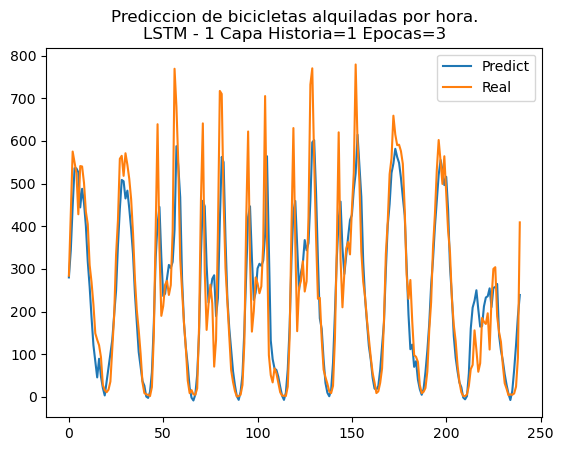

In [17]:
EPOCAS = 3

modelfpath = 'models/lstm_1_capa-{n}.keras'

n_repeticiones = 2
total_RMSE = 0

#se crean n_repeticiones modelos con los valores para los hiperparámetros obtenidos en la búsqueda,
#y se entrena durante las epocas correspondientes. Después, se promedia el RMSE del modelo en la predicción sobre el conjunto de test

#se guarda el modelo tras entrenarlo para poder recuperarlo si se necesita

for i in range(n_repeticiones):
    if os.path.isfile(modelfpath.format(n=i)):
        model=keras.saving.load_model(modelfpath.format(n=i))
    else:
        best_hp = tuner.get_best_hyperparameters()[0]
        model = build_model(best_hp)
        model.fit(x=trainX, y=trainY, batch_size=1, epochs=EPOCAS, verbose=1, shuffle=False)
        
        model.save(modelfpath.format(n=i))

    testPredict = model.predict(testX, batch_size=BATCHSIZE)
    testPredict = cnt_transformer.inverse_transform(testPredict)
    testReal=cnt_transformer.inverse_transform(testY.reshape(-1,1))
    
    rmse = math.sqrt(mean_squared_error(testReal, testPredict.reshape(-1,1)))
    total_RMSE += rmse

    print('Error cuadratico medio para el modelo {i}: {err}'.format(i = i, err = rmse))

print('\n\nRaíz del error cuadrático medio tras {n} ejecuciones: {error}'.format(n=n_repeticiones, error=total_RMSE/n_repeticiones))

model.summary()

#se muestra gráfica de predicción vs real para uno de los modelos
Visualiza('LSTM - 1 Capa')

----------------------------------------------------------------

## LSTM Utilizando una ventana temporal

Es como el modelo LSTM de una capa, salvo que ahora usamos una historia de 3 para cada entrada.

El parámetro batch_size es uno, lo que implica, que para cada ejemplo de entrenamiento aplicamos el ajuste de los pesos.

In [18]:
#repeticion de los experimentos
N_EXECUTIONS_PER_TRIAL = 3
#numero de combinacones de hiperparametros
N_TRIALS = 10
#epocas por las que entrenar
EPOCAS = 5
#historia
Historia = 3
#batchsize
BATCHSIZE = 1

trainX, trainY = CreaDatos(train, train.cnt, Historia)
testX, testY = CreaDatos(test, test.cnt, Historia)

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=16, max_value=48, step=16), input_shape=(trainX.shape[1],trainX.shape[2])))
    model.add(Dropout(rate=hp.Float('dropout-rate', min_value=0.0, max_value=0.2, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    overwrite=False,
    max_trials=10,
    executions_per_trial=N_EXECUTIONS_PER_TRIAL,
    directory='tuners-trials',
    project_name='lstm_ventana_temporal-random'
)

tuner.search(trainX, trainY, batch_size=BATCHSIZE, epochs=EPOCAS, validation_split=0.2, callbacks=my_callbacks, shuffle = False)

trials = tuner.oracle.get_best_trials(num_trials=N_TRIALS)
HP_list = []
for trial in trials:
    HP_list.append(trial.hyperparameters.get_config()["values"] | {"Val Loss": trial.score})
HP_df = pd.DataFrame(HP_list)
display(HP_df)

Reloading Tuner from tuners-trials/lstm_ventana_temporal-random/tuner0.json


,units,dropout-rate,learning_rate,Val Loss
0,48,0.0,0.0010,0.004244
1,48,0.1,0.0100,0.008960
2,32,0.0,0.0001,0.009293
3,32,0.1,0.0100,0.009410
4,48,0.1,0.0001,0.010008
5,48,0.2,0.0100,0.010089
6,16,0.1,0.0100,0.010806
7,32,0.2,0.0001,0.011068
8,32,0.1,0.0001,0.011556
9,16,0.1,0.0001,0.012915


5733/5733 [==============================] - 11s 2ms/step
Error cuadratico medio para el modelo 0: 82.83509248405568
5733/5733 [==============================] - 11s 2ms/step
Error cuadratico medio para el modelo 1: 80.35518327572069


Raíz del error cuadrático medio tras 2 ejecuciones: 81.59513787988818
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 48)                12480     
                                                                 
 dropout_3 (Dropout)         (None, 48)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 49        
                                                                 
Total params: 12529 (48.94 KB)
Trainable params: 12529 (48.94 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________

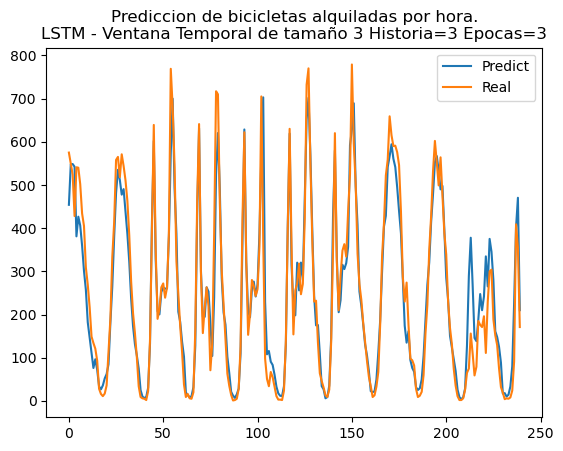

In [19]:
EPOCAS = 3

modelfpath = 'models/lstm_ventana-{n}.keras'

n_repeticiones = 2
total_RMSE = 0

for i in range(n_repeticiones):
    if os.path.isfile(modelfpath.format(n=i)):
        model=keras.saving.load_model(modelfpath.format(n=i))
    else:
        best_hp = tuner.get_best_hyperparameters()[0]
        model = build_model(best_hp)
        model.fit(x=trainX, y=trainY, batch_size=1, epochs=EPOCAS, verbose=1, shuffle=False)
        
        model.save(modelfpath.format(n=i))

    testPredict = model.predict(testX, batch_size=BATCHSIZE)
    testPredict = cnt_transformer.inverse_transform(testPredict)
    testReal=cnt_transformer.inverse_transform(testY.reshape(-1,1))
    
    # Cálculo del error cuadrático medio.
    rmse = math.sqrt(mean_squared_error(testReal, testPredict.reshape(-1,1)))
    total_RMSE += rmse

    print('Error cuadratico medio para el modelo {i}: {err}'.format(i = i, err = rmse))

print('\n\nRaíz del error cuadrático medio tras {n} ejecuciones: {error}'.format(n=n_repeticiones, error=total_RMSE/n_repeticiones))

model.summary()

Visualiza('LSTM - Ventana Temporal de tamaño 3')

----------------------------------------------------------------

## LSTM apiladas
Ahora usamos N capas LSTM (hiperparámetro) y volvemos a tener una historia de 1.

In [20]:
#repeticion de los experimentos
N_EXECUTIONS_PER_TRIAL = 3
#numero de combinacones de hiperparametros
N_TRIALS = 10
#epocas por las que entrenar
EPOCAS = 5
#historia
Historia = 1
#batchsize
BATCHSIZE = 1
#LSTM_dim escogido es el mejor encontrado para el modelo de LSTM de 1 capa

trainX, trainY = CreaDatos(train, train.cnt, Historia)
testX, testY = CreaDatos(test, test.cnt, Historia)

def build_model(hp):
    model = Sequential()
    hidden_layers = hp.Int('hiddden layers', min_value=1, max_value=4, step=1)
    model.add(LSTM(units=LSTM_dim, input_shape=(trainX.shape[1],trainX.shape[2]), return_sequences=True))
    for i in range(hidden_layers):
        if i == hidden_layers-1:
            model.add(LSTM(units=LSTM_dim))
        else:
            model.add(LSTM(units=LSTM_dim, return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout rate', min_value=0.0, max_value=0.2, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    overwrite=False,
    max_trials=10,
    executions_per_trial=N_EXECUTIONS_PER_TRIAL,
    directory='tuners-trials',
    project_name='lstm_apiladas-random'
)

tuner.search(trainX, trainY, batch_size=BATCHSIZE, epochs=EPOCAS, validation_split=0.2, callbacks=my_callbacks, shuffle = False)

trials = tuner.oracle.get_best_trials(num_trials=N_TRIALS)

HP_list = []
for trial in trials:
    HP_list.append(trial.hyperparameters.get_config()["values"] | {"Val Loss": trial.score})
HP_df = pd.DataFrame(HP_list)
display(HP_df)

Reloading Tuner from tuners-trials/lstm_apiladas-random/tuner0.json


,hiddden layers,dropout rate,learning_rate,Val Loss
0,1,0.0,0.0010,0.005475
1,3,0.0,0.0010,0.005709
2,2,0.0,0.0010,0.006440
3,4,0.2,0.0010,0.006747
4,1,0.0,0.0001,0.006872
5,3,0.1,0.0010,0.007093
6,4,0.0,0.0001,0.007211
7,3,0.0,0.0001,0.007442
8,1,0.2,0.0100,0.014176
9,2,0.1,0.0100,0.016704


5735/5735 [==============================] - 12s 2ms/step
Error cuadratico medio para el modelo 0: 129.11170545677194
5735/5735 [==============================] - 12s 2ms/step
Error cuadratico medio para el modelo 1: 112.17384246991874


Raíz del error cuadrático medio tras 2 ejecuciones: 120.64277396334535
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 48)             12480     
                                                                 
 lstm_7 (LSTM)               (None, 48)                18624     
                                                                 
 dropout_5 (Dropout)         (None, 48)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 49        
                                                                 
Total par

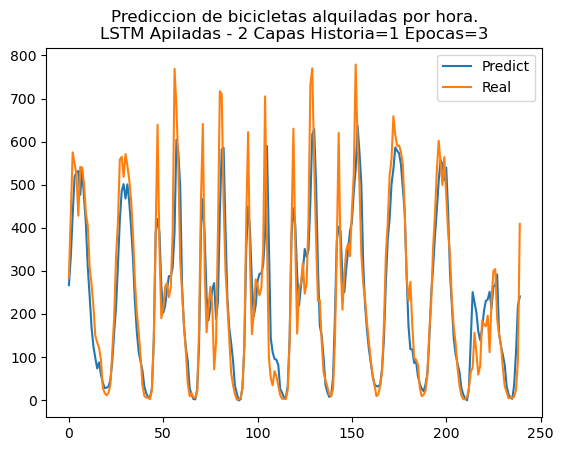

In [21]:
EPOCAS = 3

modelfpath = 'models/lstm_apiladas-{n}.keras'

n_repeticiones = 2
total_RMSE = 0

for i in range(n_repeticiones):
    if os.path.isfile(modelfpath.format(n=i)):
        model=keras.saving.load_model(modelfpath.format(n=i))
    else:
        best_hp = tuner.get_best_hyperparameters()[0]
        model = build_model(best_hp)
        model.fit(x=trainX, y=trainY, batch_size=1, epochs=EPOCAS, verbose=1, shuffle=False)
        
        model.save(modelfpath.format(n=i))

    testPredict = model.predict(testX, batch_size=BATCHSIZE)
    testPredict = cnt_transformer.inverse_transform(testPredict)
    testReal=cnt_transformer.inverse_transform(testY.reshape(-1,1))
    
    rmse = math.sqrt(mean_squared_error(testReal, testPredict.reshape(-1,1)))
    total_RMSE += rmse

    print('Error cuadratico medio para el modelo {i}: {err}'.format(i = i, err = rmse))

print('\n\nRaíz del error cuadrático medio tras {n} ejecuciones: {error}'.format(n=n_repeticiones, error=total_RMSE/n_repeticiones))

model.summary()

Visualiza('LSTM Apiladas - 2 Capas')

----------------------------------------------------------------

## LSTM con memoria entre lote y lote

Las LSTM tienen memoria (recuerdan el estado). Normalmente esta memoria se borra al empezar otro lote de entrenamiento, o cuando se calcula una nueva salida para una nueva predicción. Una nueva estrategia es que esa memoria (estado) se conserve entre lote y lote de aprendizaje (stateful), con lo que se construirá un estado sobre la secuencia completa de entrenamiento (no lote a lote), y este estado es el que se usará para hacer la predicción. Los hiperparámetros a considerar son el número de elementos LSTM, la tasa de dropout y la tasa de aprendizaje


In [22]:
#repeticion de los experimentos
N_EXECUTIONS_PER_TRIAL = 3
#numero de combinacones de hiperparametros
N_TRIALS = 10
#epocas por las que entrenar
EPOCAS = 5
#historia
Historia = 1
#batchsize
BATCHSIZE = 1


trainX, trainY = CreaDatos(train, train.cnt, Historia)
testX, testY = CreaDatos(test, test.cnt, Historia)


def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=16, max_value=48, step=16), batch_input_shape=(BATCHSIZE, trainX.shape[1], trainX.shape [2]), stateful=True))
    model.add(Dropout(rate=hp.Float('dropout rate', min_value=0.0, max_value=0.2, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

#sobreescribimos el tuner, y decimos que al final de cada epoch se invoque a reset_states
class RandomSearchLSTMConMemoria(RandomSearch):
    def on_epoch_end(self, trial, model, epoch, logs=None):
        model.reset_states()
        super(RandomSearch, self).on_epoch_end(trial, model, epoch, logs)
        
tuner = RandomSearchLSTMConMemoria(
    build_model,
    objective='val_loss',
    overwrite=False,
    max_trials=N_TRIALS,
    executions_per_trial=N_EXECUTIONS_PER_TRIAL,
    directory='tuners-trials',
    project_name='lstm_memoria_entre_lotes-random'
)

tuner.search(trainX, trainY, batch_size=BATCHSIZE, epochs=EPOCAS, validation_split=0.2, callbacks=my_callbacks, shuffle = False)

trials = tuner.oracle.get_best_trials(num_trials=N_TRIALS)

HP_list = []
for trial in trials:
    HP_list.append(trial.hyperparameters.get_config()["values"] | {"Val Loss": trial.score})
HP_df = pd.DataFrame(HP_list)
display(HP_df)

Reloading Tuner from tuners-trials/lstm_memoria_entre_lotes-random/tuner0.json


,units,dropout rate,learning_rate,Val Loss
0,16,0.2,0.0010,0.004926
1,48,0.2,0.0001,0.006756
2,48,0.0,0.0001,0.006963
3,32,0.0,0.0001,0.007816
4,32,0.2,0.0100,0.011080
5,48,0.2,0.0100,0.011556
6,16,0.2,0.0100,0.011787
7,48,0.1,0.0100,0.012164
8,16,0.0,0.0100,0.012457
9,16,0.2,0.0001,0.013669


5735/5735 [==============================] - 11s 2ms/step
Error cuadratico medio para el modelo 0: 93.30360352949536
5735/5735 [==============================] - 11s 2ms/step
Error cuadratico medio para el modelo 1: 109.10974323843956


Raíz del error cuadrático medio tras 2 ejecuciones: 101.20667338396746
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (1, 16)                   2112      
                                                                 
 dropout_7 (Dropout)         (1, 16)                   0         
                                                                 
 dense_7 (Dense)             (1, 1)                    17        
                                                                 
Total params: 2129 (8.32 KB)
Trainable params: 2129 (8.32 KB)
Non-trainable params: 0 (0.00 Byte)
____________________________________________

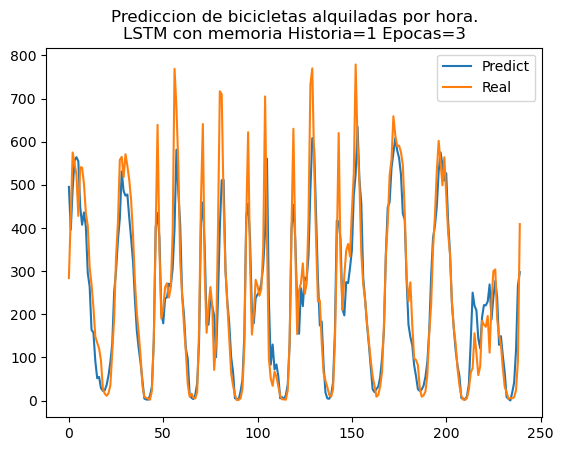

In [23]:
EPOCAS = 3

modelfpath = 'models/lstm_memoria-{n}.keras'

n_repeticiones = 2
total_RMSE = 0

for i in range(n_repeticiones):
    if os.path.isfile(modelfpath.format(n=i)):
        model=keras.saving.load_model(modelfpath.format(n=i))
    else:
        best_hp = tuner.get_best_hyperparameters()[0]
        model = build_model(best_hp)
        model.fit(x=trainX, y=trainY, batch_size=1, epochs=EPOCAS, verbose=1, shuffle=False)
        
        model.save(modelfpath.format(n=i))

    testPredict = model.predict(testX, batch_size=BATCHSIZE)
    testPredict = cnt_transformer.inverse_transform(testPredict)
    testReal=cnt_transformer.inverse_transform(testY.reshape(-1,1))
    
    # Cálculo del error cuadrático medio.
    rmse = math.sqrt(mean_squared_error(testReal, testPredict.reshape(-1,1)))
    total_RMSE += rmse

    print('Error cuadratico medio para el modelo {i}: {err}'.format(i = i, err = rmse))

print('\n\nRaíz del error cuadrático medio tras {n} ejecuciones: {error}'.format(n=n_repeticiones, error=total_RMSE/n_repeticiones))

model.summary()

Visualiza('LSTM con memoria')

----------------------------------------------------------------

## LSTM's apilados (varias capas) con memoria entre lote y lote

Añadimos al caso de LSTM apiladas el hecho de que vamos a alimentar la siguiente capa LSTM con la secuencia y el estado.

In [24]:
#repeticion de los experimentos
N_EXECUTIONS_PER_TRIAL = 3
#numero de combinacones de hiperparametros
N_TRIALS = 10
#epocas por las que entrenar
EPOCAS = 5
#historia
Historia = 1
#batch size
BATCHSIZE = 1
#LSTM_dim
LSTM_dim = tuner.get_best_hyperparameters()[0]['units']


trainX, trainY = CreaDatos(train, train.cnt, Historia)
testX, testY = CreaDatos(test, test.cnt, Historia)


def build_model(hp):
    model = Sequential()
    hidden_layers = hp.Int('hiddden layers', min_value=1, max_value=4, step=1)

    model.add(LSTM(units=LSTM_dim, batch_input_shape=(BATCHSIZE, trainX.shape[1], trainX.shape [2]), stateful=True, return_sequences=True))
    
    for i in range(hidden_layers):
        if i == hidden_layers-1:
            model.add(LSTM(units=LSTM_dim, stateful=True))
        else:
            model.add(LSTM(units=LSTM_dim, stateful=True, return_sequences=True))
            
    model.add(Dropout(rate=hp.Float('dropout rate', min_value=0.0, max_value=0.2, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model
        
tuner = RandomSearchLSTMConMemoria(
    build_model,
    objective='val_loss',
    overwrite=False,
    max_trials=N_TRIALS,
    executions_per_trial=N_EXECUTIONS_PER_TRIAL,
    directory='tuners-trials',
    project_name='lstm_apiladas_memoria_entre_lotes-random'
)

tuner.search(trainX, trainY, batch_size=BATCHSIZE, epochs=EPOCAS, validation_split=0.2, callbacks=my_callbacks, shuffle = False)

trials = tuner.oracle.get_best_trials(num_trials=N_TRIALS)

HP_list = []
for trial in trials:
    HP_list.append(trial.hyperparameters.get_config()["values"] | {"Val Loss": trial.score})
HP_df = pd.DataFrame(HP_list)
display(HP_df)

Reloading Tuner from tuners-trials/lstm_apiladas_memoria_entre_lotes-random/tuner0.json


,hiddden layers,dropout rate,learning_rate,Val Loss
0,1,0.1,0.0010,0.005284
1,3,0.0,0.0010,0.005295
2,2,0.0,0.0010,0.005371
3,3,0.1,0.0010,0.005404
4,4,0.0,0.0010,0.007296
5,3,0.0,0.0001,0.007448
6,1,0.0,0.0100,0.011854
7,2,0.0,0.0100,0.016311
8,2,0.2,0.0100,0.017312
9,3,0.0,0.0100,0.023779


5735/5735 [==============================] - 12s 2ms/step
Error cuadratico medio para el modelo 0: 98.1109539147995
5735/5735 [==============================] - 12s 2ms/step
Error cuadratico medio para el modelo 1: 99.25191654943434


Raíz del error cuadrático medio tras 2 ejecuciones: 98.68143523211691
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (1, 1, 16)                2112      
                                                                 
 lstm_13 (LSTM)              (1, 16)                   2112      
                                                                 
 dropout_9 (Dropout)         (1, 16)                   0         
                                                                 
 dense_9 (Dense)             (1, 1)                    17        
                                                                 
Total params:

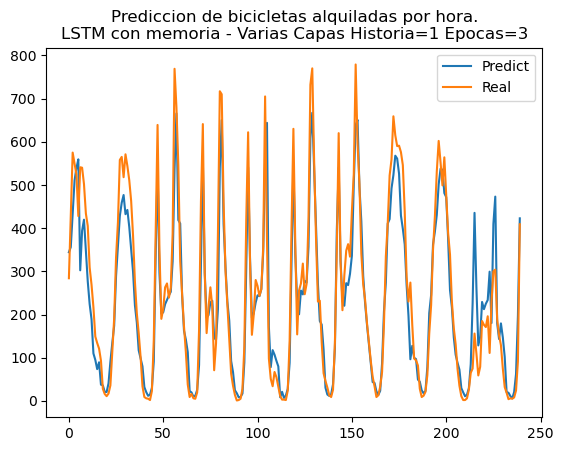

In [25]:
EPOCAS = 3

modelfpath = 'models/lstm_memoria_apiladas-{n}.keras'

n_repeticiones = 2
total_RMSE = 0

for i in range(n_repeticiones):
    if os.path.isfile(modelfpath.format(n=i)):
        model=keras.saving.load_model(modelfpath.format(n=i))
    else:
        best_hp = tuner.get_best_hyperparameters()[0]
        model = build_model(best_hp)
        model.fit(x=trainX, y=trainY, batch_size=1, epochs=EPOCAS, verbose=1, shuffle=False)
        
        model.save(modelfpath.format(n=i))

    testPredict = model.predict(testX, batch_size=BATCHSIZE)
    testPredict = cnt_transformer.inverse_transform(testPredict)
    testReal=cnt_transformer.inverse_transform(testY.reshape(-1,1))
    
    # Cálculo del error cuadrático medio.
    rmse = math.sqrt(mean_squared_error(testReal, testPredict.reshape(-1,1)))
    total_RMSE += rmse

    print('Error cuadratico medio para el modelo {i}: {err}'.format(i = i, err = rmse))

print('\n\nRaíz del error cuadrático medio tras {n} ejecuciones: {error}'.format(n=n_repeticiones, error=total_RMSE/n_repeticiones))

model.summary()

Visualiza('LSTM con memoria - Varias Capas')

----------------------------------------------------------------

## GRU - 1 Capa

Este modelo es igual al primero (LSTM de 1 capa), pero utilizando módulos GRU en lugar de LSTM, que tardan menos en entrenar al tener menos parámetros

In [26]:
#repeticion de los experimentos
N_EXECUTIONS_PER_TRIAL = 3
#numero de combinacones de hiperparametros
N_TRIALS = 10
#epocas por las que entrenar
EPOCAS = 5
#historia
Historia = 1
#batchsize
BATCHSIZE = 1

trainX, trainY = CreaDatos(train, train.cnt, Historia)
testX, testY = CreaDatos(test, test.cnt, Historia)

def build_model(hp):
    model = Sequential()
    model.add(GRU(units=hp.Int('units', min_value=16, max_value=48, step=16), input_shape=(trainX.shape[1],trainX.shape[2])))
    model.add(Dropout(rate=hp.Float('dropout-rate', min_value=0.0, max_value=0.2, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    overwrite=False,
    max_trials=10,
    executions_per_trial=N_EXECUTIONS_PER_TRIAL,
    directory='tuners-trials',
    project_name='gru_1_capa-random'
)

tuner.search(trainX, trainY, batch_size=BATCHSIZE, epochs=EPOCAS, validation_split=0.2, callbacks=my_callbacks, shuffle = False)

trials = tuner.oracle.get_best_trials(num_trials=N_TRIALS)
HP_list = []
for trial in trials:
    HP_list.append(trial.hyperparameters.get_config()["values"] | {"Val Loss": trial.score})
HP_df = pd.DataFrame(HP_list)
display(HP_df)

Reloading Tuner from tuners-trials/gru_1_capa-random/tuner0.json


,units,dropout-rate,learning_rate,Val Loss
0,32,0.0,0.0010,0.005256
1,16,0.0,0.0010,0.005839
2,48,0.2,0.0010,0.006574
3,32,0.2,0.0010,0.006675
4,48,0.0,0.0001,0.007145
5,48,0.1,0.0100,0.010899
6,16,0.1,0.0001,0.012423
7,16,0.2,0.0001,0.013104
8,48,0.0,0.0100,0.013271
9,32,0.0,0.0100,0.014460


5735/5735 [==============================] - 10s 2ms/step
Error cuadratico medio para el modelo 0: 130.38722481311058
5735/5735 [==============================] - 10s 2ms/step
Error cuadratico medio para el modelo 1: 126.16217964732516


Raíz del error cuadrático medio tras 2 ejecuciones: 128.27470223021788
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 32)                4800      
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4833 (18.88 KB)
Trainable params: 4833 (18.88 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________

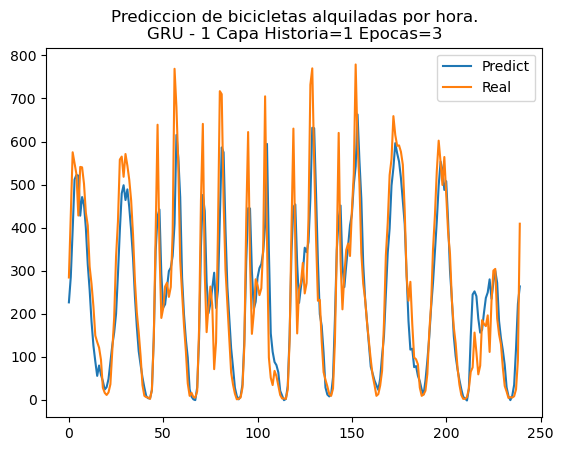

In [27]:
EPOCAS = 3

modelfpath = 'models/gru_1_capa-{n}.keras'

n_repeticiones = 2
total_RMSE = 0

for i in range(n_repeticiones):
    if os.path.isfile(modelfpath.format(n=i)):
        model=keras.saving.load_model(modelfpath.format(n=i))
    else:
        best_hp = tuner.get_best_hyperparameters()[0]
        model = build_model(best_hp)
        model.fit(x=trainX, y=trainY, batch_size=1, epochs=EPOCAS, verbose=1, shuffle=False)
        
        model.save(modelfpath.format(n=i))

    testPredict = model.predict(testX, batch_size=BATCHSIZE)
    testPredict = cnt_transformer.inverse_transform(testPredict)
    testReal=cnt_transformer.inverse_transform(testY.reshape(-1,1))
    
    # Cálculo del error cuadrático medio.
    rmse = math.sqrt(mean_squared_error(testReal, testPredict.reshape(-1,1)))
    total_RMSE += rmse

    print('Error cuadratico medio para el modelo {i}: {err}'.format(i = i, err = rmse))

print('\n\nRaíz del error cuadrático medio tras {n} ejecuciones: {error}'.format(n=n_repeticiones, error=total_RMSE/n_repeticiones))
    
model.summary()

Visualiza('GRU - 1 Capa')

----------------------------------------------------------------